In [1]:
import CNN_lib
import CNN_utilities
import fig_lib 
import CNN_machine

import numpy as np
import pickle
import json

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# SETTINGS

In [2]:
trains_n=10

data_split='rnd_patients'                                # 'rnd_recs' 'rnd_patients'

checking_on=False
t_btw_frm=0.05
check_record_1= '670615_19'
check_record_2= 'ROT_670615_19'

In [3]:
number_data_ls = [i for i in range(48, 530, 32)]
#number_data_ls = [i for i in range(48, 530, 119)]
models_d = {'model'+'_'+str(n):{'path':None,'name':None,'samples':n} for n in number_data_ls}

epochs = 3

models_d

{'model_48': {'path': None, 'name': None, 'samples': 48},
 'model_167': {'path': None, 'name': None, 'samples': 167},
 'model_286': {'path': None, 'name': None, 'samples': 286},
 'model_405': {'path': None, 'name': None, 'samples': 405},
 'model_524': {'path': None, 'name': None, 'samples': 524}}

### DATA SPLIT

In [4]:
if data_split == 'rnd_recs': test_size=0.2           

elif data_split == 'rnd_patients': patiens_split =[10,5]

### DATA AUGMENTATION

In [5]:
n_flip_1,n_flip_0=0.7 , 0.07

n_rot_1,n_rot_0=0.7 , 0.07

n_contr_1,n_contr_0=0.4 , 0.04

n_bright_1,n_bright_0=0.4 , 0.04

aug_params={'f1':n_flip_1,'f0':n_flip_0,'r1':n_rot_1,'r0':n_rot_0,'c1':n_contr_1,'c0':n_contr_0,'b1':n_bright_1,'b0':n_bright_0}

### PATHS

In [6]:
checkpoint_path = "C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static/checkpoints"
pkl_train_p='C:\PROJECTS\emboendo\CNN/pikles/processed_train_d.pkl'  

for n in number_data_ls:
    
    models_d['model'+'_'+str(n)]['path']=checkpoint_path+'_'+str(n)+'.h5'
    models_d['model'+'_'+str(n)]['name']='MODEL'+ ' ' + str(n)


check_points_p = [checkpoint_path+'_'+str(n)+'.h5' for n in range(trains_n)]

if data_split == 'rnd_patients': json_fix_sq_p='C:\PROJECTS\emboendo\dicom_viewer\_static\Jsons\points_fix_d.json'

# GENERATE TRAIN DATA

In [7]:
if data_split == 'rnd_patients':

    with open(json_fix_sq_p, 'r') as json_file:
        json_d = json.load(json_file)

    patients_d_df =  CNN_utilities.gen_patients_d_df(json_d)

In [8]:
with open(pkl_train_p, 'rb') as pikle_file:

    save_trains= pickle.load(pikle_file)

x_train,y_train,rcs =  save_trains[0],save_trains[1],save_trains[2]

max_frm_n, HEIGHT, WIDTH=np.shape(x_train)[1],np.shape(x_train)[2],np.shape(x_train)[3]
input_shape=(max_frm_n, HEIGHT, WIDTH, 1)

## MAIN DATA SHUFFLE

In [9]:
X_train,Y_train,recs=CNN_lib.shuffle(x_train,y_train,rcs)

# CNN

In [10]:
models=[CNN_machine.Gen_Model(aug_params,patients_d_df,name=values['name'],path=values['path'],input_shape=input_shape,samples=values['samples']) for values in models_d.values()]

In [11]:
for mdl in models:
    
    print(f'---------------------------------- ---------------------------------- ---------- ---------------------------------- ----------------------------------')
    print(f'---------------------------------- ---------------------------------- {mdl.name} ---------------------------------- ----------------------------------')
    print(f'---------------------------------- ---------------------------------- ---------- ---------------------------------- ----------------------------------')
    print(' ')

    mdl.train_model(X_train,Y_train,recs, epochs,trains_n,patiens_split)

    print(' ')
    print(' ')

---------------------------------- ---------------------------------- ---------- ---------------------------------- ----------------------------------
---------------------------------- ---------------------------------- MODEL 48 ---------------------------------- ----------------------------------
---------------------------------- ---------------------------------- ---------- ---------------------------------- ----------------------------------
 
(660, 40, 160, 160, 1) (660,) 660
Epoch 1/3
3/3 [==============================] - 3s 697ms/step - loss: 0.7129 - accuracy: 0.4634 - val_loss: 0.6913 - val_accuracy: 0.6444
Epoch 2/3


c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 2s 604ms/step - loss: 0.6849 - accuracy: 0.6951 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 3/3
3/3 [==============================] - 2s 600ms/step - loss: 0.6691 - accuracy: 0.6707 - val_loss: 0.7270 - val_accuracy: 0.4000
 
-------------- ITERATION 1/3 COMPLETED --------------
 
3/3 [==============================] - 0s 123ms/step
(660, 40, 160, 160, 1) (660,) 660
Epoch 1/3
3/3 [==============================] - 2s 733ms/step - loss: 0.6801 - accuracy: 0.5795 - val_loss: 0.8036 - val_accuracy: 0.2946
Epoch 2/3
3/3 [==============================] - 2s 688ms/step - loss: 0.6506 - accuracy: 0.5909 - val_loss: 0.7874 - val_accuracy: 0.3571
Epoch 3/3
3/3 [==============================] - 2s 707ms/step - loss: 0.6370 - accuracy: 0.6023 - val_loss: 0.6803 - val_accuracy: 0.5893


c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 
-------------- ITERATION 2/3 COMPLETED --------------
 
4/4 [==============================] - 1s 114ms/step
(660, 40, 160, 160, 1) (660,) 660
Epoch 1/3
3/3 [==============================] - 2s 742ms/step - loss: 0.7087 - accuracy: 0.4750 - val_loss: 0.6217 - val_accuracy: 0.6692
Epoch 2/3


c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 2s 650ms/step - loss: 0.6512 - accuracy: 0.5875 - val_loss: 0.6403 - val_accuracy: 0.6308
Epoch 3/3
3/3 [==============================] - 2s 674ms/step - loss: 0.5783 - accuracy: 0.7500 - val_loss: 0.6563 - val_accuracy: 0.6385
 
-------------- ITERATION 3/3 COMPLETED --------------
 
5/5 [==============================] - 1s 103ms/step
 
 
---------------------------------- ---------------------------------- ---------- ---------------------------------- ----------------------------------
---------------------------------- ---------------------------------- MODEL 167 ---------------------------------- ----------------------------------
---------------------------------- ---------------------------------- ---------- ---------------------------------- ----------------------------------
 
(660, 40, 160, 160, 1) (660,) 660
Epoch 1/3
10/10 [==============================] - 6s 523ms/step - loss: 0.6781 - accuracy: 0.5631 - val_loss: 0.6640 - val_accur

c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 5s 493ms/step - loss: 0.6729 - accuracy: 0.6246 - val_loss: 0.7983 - val_accuracy: 0.4211
Epoch 3/3
10/10 [==============================] - 5s 493ms/step - loss: 0.6278 - accuracy: 0.6724 - val_loss: 0.7260 - val_accuracy: 0.5702
 
-------------- ITERATION 1/3 COMPLETED --------------
 
4/4 [==============================] - 1s 108ms/step
(660, 40, 160, 160, 1) (660,) 660
Epoch 1/3
10/10 [==============================] - 5s 516ms/step - loss: 0.6784 - accuracy: 0.5724 - val_loss: 0.6913 - val_accuracy: 0.5826
Epoch 2/3
10/10 [==============================] - 5s 496ms/step - loss: 0.6241 - accuracy: 0.6700 - val_loss: 0.9114 - val_accuracy: 0.4087
Epoch 3/3
10/10 [==============================] - 5s 498ms/step - loss: 0.5972 - accuracy: 0.6835 - val_loss: 0.8611 - val_accuracy: 0.4087
 
-------------- ITERATION 2/3 COMPLETED --------------
 
4/4 [==============================] - 1s 118ms/step
(660, 40, 160, 160, 1) (660,) 660
Epoch 1/3
9/9 [

c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 529ms/step - loss: 0.5536 - accuracy: 0.7085 - val_loss: 0.7450 - val_accuracy: 0.5950
Epoch 3/3
9/9 [==============================] - 5s 544ms/step - loss: 0.5190 - accuracy: 0.7380 - val_loss: 0.7624 - val_accuracy: 0.5868
 
-------------- ITERATION 3/3 COMPLETED --------------
 
4/4 [==============================] - 1s 127ms/step
 
 
---------------------------------- ---------------------------------- ---------- ---------------------------------- ----------------------------------
---------------------------------- ---------------------------------- MODEL 286 ---------------------------------- ----------------------------------
---------------------------------- ---------------------------------- ---------- ---------------------------------- ----------------------------------
 
(660, 40, 160, 160, 1) (660,) 660
Epoch 1/3
16/16 [==============================] - 9s 521ms/step - loss: 0.7009 - accuracy: 0.5298 - val_loss: 0.7030 - val_accur

c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 8s 509ms/step - loss: 0.6730 - accuracy: 0.5774 - val_loss: 0.6515 - val_accuracy: 0.6857
Epoch 3/3
16/16 [==============================] - 10s 667ms/step - loss: 0.6173 - accuracy: 0.6687 - val_loss: 0.6797 - val_accuracy: 0.6476
 
-------------- ITERATION 1/3 COMPLETED --------------
 
4/4 [==============================] - 1s 244ms/step
(660, 40, 160, 160, 1) (660,) 660
Epoch 1/3
15/15 [==============================] - 10s 594ms/step - loss: 0.6226 - accuracy: 0.6632 - val_loss: 0.7237 - val_accuracy: 0.5877
Epoch 2/3
15/15 [==============================] - 12s 838ms/step - loss: 0.5706 - accuracy: 0.6883 - val_loss: 0.6797 - val_accuracy: 0.5614
Epoch 3/3
15/15 [==============================] - 18s 1s/step - loss: 0.4495 - accuracy: 0.7803 - val_loss: 0.7932 - val_accuracy: 0.5351
 
-------------- ITERATION 2/3 COMPLETED --------------
 
4/4 [==============================] - 1s 266ms/step
(660, 40, 160, 160, 1) (660,) 660
Epoch 1/3
16/1

c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 12s 724ms/step - loss: 0.5059 - accuracy: 0.7562 - val_loss: 0.5475 - val_accuracy: 0.7379
Epoch 3/3
16/16 [==============================] - 8s 485ms/step - loss: 0.4027 - accuracy: 0.8223 - val_loss: 0.5964 - val_accuracy: 0.7184
 
-------------- ITERATION 3/3 COMPLETED --------------
 
4/4 [==============================] - 0s 99ms/step
 
 
---------------------------------- ---------------------------------- ---------- ---------------------------------- ----------------------------------
---------------------------------- ---------------------------------- MODEL 405 ---------------------------------- ----------------------------------
---------------------------------- ---------------------------------- ---------- ---------------------------------- ----------------------------------
 
(660, 40, 160, 160, 1) (660,) 660
Epoch 1/3
22/22 [==============================] - 12s 517ms/step - loss: 0.6899 - accuracy: 0.5462 - val_loss: 0.6853 - val_

c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 11s 509ms/step - loss: 0.6123 - accuracy: 0.6728 - val_loss: 0.7987 - val_accuracy: 0.5000
Epoch 3/3
22/22 [==============================] - 11s 503ms/step - loss: 0.5583 - accuracy: 0.7070 - val_loss: 0.9341 - val_accuracy: 0.3426
 
-------------- ITERATION 1/3 COMPLETED --------------
 
4/4 [==============================] - 1s 107ms/step
(660, 40, 160, 160, 1) (660,) 660
Epoch 1/3
22/22 [==============================] - 12s 519ms/step - loss: 0.5497 - accuracy: 0.7226 - val_loss: 0.7947 - val_accuracy: 0.6479
Epoch 2/3
22/22 [==============================] - 11s 516ms/step - loss: 0.4217 - accuracy: 0.8122 - val_loss: 0.8277 - val_accuracy: 0.6479
Epoch 3/3
22/22 [==============================] - 11s 509ms/step - loss: 0.3411 - accuracy: 0.8464 - val_loss: 0.8837 - val_accuracy: 0.6549
 
-------------- ITERATION 2/3 COMPLETED --------------
 
5/5 [==============================] - 1s 115ms/step
(660, 40, 160, 160, 1) (660,) 660
Epoch 1/3


c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 11s 511ms/step - loss: 0.3944 - accuracy: 0.8193 - val_loss: 0.3570 - val_accuracy: 0.8496
Epoch 3/3
22/22 [==============================] - 11s 507ms/step - loss: 0.2631 - accuracy: 0.9061 - val_loss: 0.4181 - val_accuracy: 0.7965
 
-------------- ITERATION 3/3 COMPLETED --------------
 
4/4 [==============================] - 0s 117ms/step
 
 
---------------------------------- ---------------------------------- ---------- ---------------------------------- ----------------------------------
---------------------------------- ---------------------------------- MODEL 524 ---------------------------------- ----------------------------------
---------------------------------- ---------------------------------- ---------- ---------------------------------- ----------------------------------
 
(660, 40, 160, 160, 1) (660,) 660
Epoch 1/3
28/28 [==============================] - 15s 499ms/step - loss: 0.6916 - accuracy: 0.5526 - val_loss: 0.6979 - va

c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 14s 497ms/step - loss: 0.6331 - accuracy: 0.6396 - val_loss: 0.6961 - val_accuracy: 0.5897
Epoch 3/3
28/28 [==============================] - 14s 495ms/step - loss: 0.5237 - accuracy: 0.7265 - val_loss: 0.8459 - val_accuracy: 0.4786
 
-------------- ITERATION 1/3 COMPLETED --------------
 
4/4 [==============================] - 1s 124ms/step
(660, 40, 160, 160, 1) (660,) 660
Epoch 1/3
29/29 [==============================] - 15s 497ms/step - loss: 0.6005 - accuracy: 0.6878 - val_loss: 0.6319 - val_accuracy: 0.6667
Epoch 2/3


c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 14s 487ms/step - loss: 0.4728 - accuracy: 0.7844 - val_loss: 0.7755 - val_accuracy: 0.6574
Epoch 3/3
29/29 [==============================] - 14s 486ms/step - loss: 0.4230 - accuracy: 0.8167 - val_loss: 0.6806 - val_accuracy: 0.6481
 
-------------- ITERATION 2/3 COMPLETED --------------
 
4/4 [==============================] - 0s 110ms/step
(660, 40, 160, 160, 1) (660,) 660
Epoch 1/3
28/28 [==============================] - 14s 513ms/step - loss: 0.5756 - accuracy: 0.7103 - val_loss: 0.4934 - val_accuracy: 0.7788
Epoch 2/3


c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 14s 510ms/step - loss: 0.4384 - accuracy: 0.7819 - val_loss: 0.5061 - val_accuracy: 0.7500
Epoch 3/3
28/28 [==============================] - 14s 498ms/step - loss: 0.3238 - accuracy: 0.8658 - val_loss: 0.5650 - val_accuracy: 0.7115
 
-------------- ITERATION 3/3 COMPLETED --------------
 
4/4 [==============================] - 0s 103ms/step
 
 


In [12]:
#for mdl in models:CNN_lib.plot_train_eval(mdl.history,epochs)

In [13]:
#for mdl in models: CNN_lib.plot_roc_curve(mdl.fpr_val,mdl.tpr_val,mdl.roc_auc)

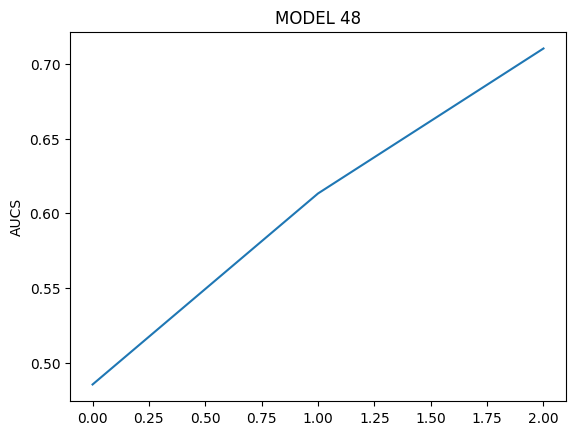

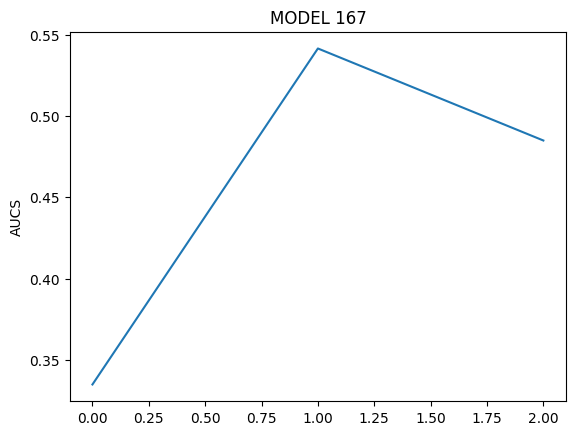

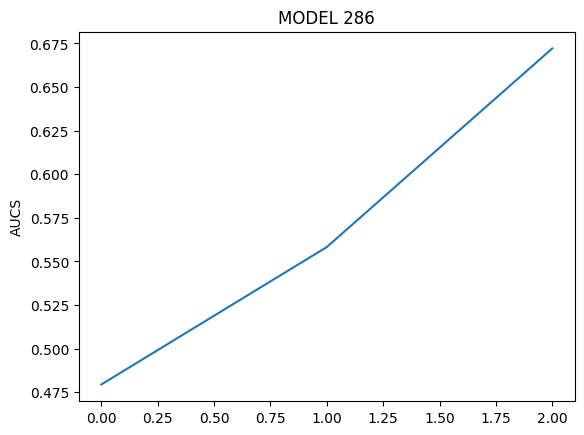

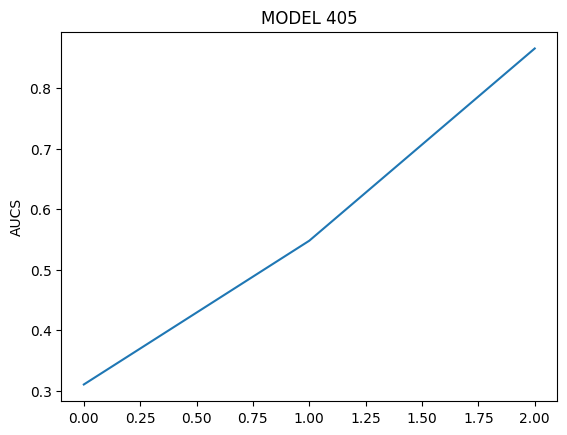

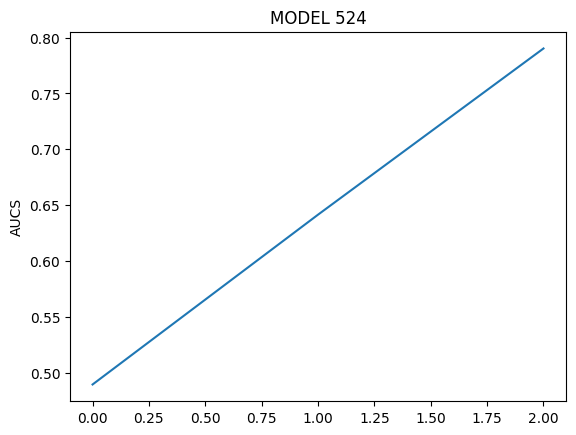

In [14]:
for mdl in models:CNN_lib.list_plot(mdl.roc_aucs,title=mdl.name,ylabel='AUCS')

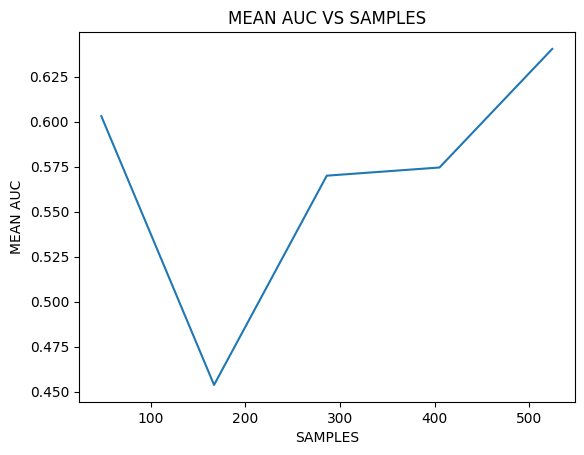

In [15]:
AUC_ls=[np.mean(mdl.roc_aucs) for mdl in models]
number_points=[mdl.samples for mdl in models]



CNN_lib.simple_plot(number_points,AUC_ls,title='MEAN AUC VS SAMPLES',xlabel='SAMPLES',ylabel='MEAN AUC')